# Janus gym environment

In [53]:
import gym
from gym import spaces
import random
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, DDPG
from math import sqrt
import numpy as np
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

class Janus(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(Janus, self).__init__()
        #actions: move on the grid, by continuous value in -1,1 
        #0,0 no move
        #based on 98 controlable parameters
        #"We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) ", we will multiply effect by 2
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(98,))
        
        # all the observation_space
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(325,))
        
    
    def reset(self):
        self.current_position = self.observation_space.sample()
        self.last_action = np.array([])
        self.last_effect = False
        self.global_reward = 0
        print(f'reset at position {self.current_position}')
        return self.current_position
        
    def step(self, action):
        action *= 2
        effect = False
        if ((action[0]+self.current_position[1]<5) & (action[0]+self.current_position[1]>0)):
            effect = True
            self.current_position[1] += action[0]
        if ((action[1]+self.current_position[0]<5) & (action[1]+self.current_position[0]>0)):
            effect = True
            self.current_position[0] += action[1]

        reward = -10
        
        if (self.last_action.size > 0):
            ## can be used to compare to last action if it is valid
            pass
        self.last_action = action
        self.last_effect = effect

        done = False
        if (self.current_position[0] > 4) & (self.current_position[1] > 4):
            reward = 100
            done = True
        self.global_reward += reward
        return self.current_position, reward, done, {}
            
    
    def render(self):
        print(f'position {self.current_position}, action {self.last_action}, effect {self.last_effect}, done {done}, global_reward {self.global_reward}')
        
    def convert_to_real_obs(self, observation, observation_dataset):
        '''
        observation: instance of observation_space
        '''
        return (observation +np.ones(self.observation_space.shape))/2 * (observation_dataset.max()-observation_dataset.min())+observation_dataset.min()
        



# load of data

In [7]:
import numpy as np
import pandas as pd

template_filename = 'data/dataset-S_public/public/dataset_S-{}.csv'


file1 = pd.read_csv(template_filename.format('file1'), index_col=0)
file3 = pd.read_csv(template_filename.format('file3'), index_col=0)

In [33]:
print(f'valeur min dans le dataset {min(file3.min())}, \ntop 5 min \n {file3.min()[file3.min().argsort()].head(5)}')
print(f'valeur maxi dans le dataset {max(file3.max())}, \ntop 5 max \n {file3.max()[file3.max().argsort(reversed)].tail(5)}')


valeur min dans le dataset -13266.208031209428, 
top 5 min 
 data_35   -13266.208031
data_64      -81.066595
data_54      -80.048077
data_38      -58.773270
data_6       -31.377531
dtype: float64
valeur maxi dans le dataset 11187.080152500184, 
top 5 max 
 data_88      961.717861
data_87     1436.915935
data_53     1436.915935
data_63     1999.338904
data_64    11187.080153
dtype: float64


In [34]:
file3.describe()

,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,...,data_315,data_316,data_317,data_318,data_319,data_320,data_321,data_322,data_323,data_324
count,13639.000000,13639.000000,13639.000000,13639.0,13639.0,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,...,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000
mean,0.006749,-0.042141,0.020207,0.0,0.0,-0.076367,0.012645,0.333411,0.051388,0.051303,...,-0.038504,-0.025678,-0.027770,0.055177,0.057303,0.055709,-0.031514,-0.024710,-0.006076,0.039658
std,1.252618,0.730117,1.231389,0.0,0.0,1.033150,1.006611,7.226308,1.004473,1.004542,...,0.996080,1.066681,0.991445,0.971180,1.157526,0.987968,1.006784,1.330478,0.990435,0.997304
min,-19.168525,-1.385061,-6.845543,0.0,0.0,-3.015342,-31.377531,-3.018091,-3.538492,-3.538492,...,-4.124391,-14.343231,-4.034838,-3.180928,-26.006003,-3.031386,-3.386451,-16.194757,-3.608651,-1.278469
25%,0.416824,-0.162994,-0.013106,0.0,0.0,-0.791116,-0.996154,-0.811167,-0.659694,-0.659694,...,-0.554152,-0.584948,-0.557652,-0.594019,-0.602010,-0.582388,-0.562853,-0.618133,-0.552126,-1.278469
50%,0.416824,-0.162994,-0.013106,0.0,0.0,-0.155623,0.369301,0.134657,-0.199086,-0.199086,...,0.087558,0.075623,0.105493,0.138939,0.131212,0.148015,-0.030758,-0.015981,0.012914,-0.389000
75%,0.416824,-0.122259,0.214642,0.0,0.0,0.797617,0.710665,0.765207,0.722129,0.722129,...,0.641762,0.654976,0.636008,0.656321,0.778173,0.706558,0.648925,0.604199,0.650006,0.500468
max,15.805312,10.835603,43.714493,0.0,0.0,2.386350,2.076120,129.031368,3.946383,3.946383,...,2.596059,24.099828,2.608143,3.545036,17.038454,2.854802,3.425915,75.004214,3.551050,1.389936


In [54]:
env_test = Janus()
from stable_baselines3.common.env_checker import check_env

# check_env(env_test)

env_test.convert_to_real_obs(env_test.observation_space.sample(), file3)

data_0      13.443018
data_1      10.577920
data_2      22.908181
data_3       0.000000
data_4       0.000000
              ...    
data_320     1.738754
data_321    -2.756717
data_322    -6.357449
data_323    -0.637003
data_324     0.956606
Length: 325, dtype: float64

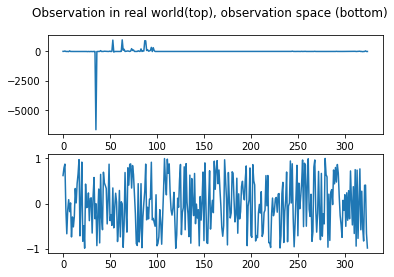

In [63]:
obs = env_test.observation_space.sample()
arr = env_test.convert_to_real_obs(obs, file3)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Observation in real world(top), observation space (bottom)')
ax1.plot(np.arange(0, len(arr)), arr)
ax2.plot(np.arange(0, len(arr)), obs)
plt.show()

# prediction and reward calculation